### Dimensionality Reduction 
#### Part III
Checking out a new dataset using preprocessing strategy outlined in `tSNE_v_PCA.ipynb` and `metric.ipynb`

In [1]:
import fcc_utils

import numpy as np
import scipy as sc
import pandas as pd

# package for reading in data files
import h5py

# scikit packages
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import KFold

# import tsne packages
from sklearn.manifold import TSNE

# import density peak clustering
from pydpc import Cluster

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')
%matplotlib inline

In [2]:
# read in tumor hdf5 file
tumor = fcc_utils.read_hdf5('inputs/1291_AS_2_tumor.hdf5')

In [3]:
# see what's in it...
tumor.keys()

dict_keys(['Counts', 'Transcripts'])

In [4]:
# 'counts' frame must have data in it
tumor_data = tumor['Counts']
tumor_data.shape

(12309, 38254)

In [5]:
# and the 'transcripts' vector has the names of each transcript
print(tumor['Transcripts'].shape)
tumor['Transcripts'][0:3]

(38254,)


array([b'0610006L08Rik', b'0610007P14Rik', b'0610009B22Rik'], dtype=object)

So this data is of shape *(n_cells, n_genes)*, and the genes are labeled nicely for us in the `tumor-data['Transcripts']` vector.

In [6]:
# let's take a subset of this data so it isn't too computationally expensive
tumor_data_1 = tumor_data[np.random.choice(tumor_data.shape[0], size=5000)]

tumor_data_1.shape # confirm it's the right shape = (size, 32854)

(5000, 38254)

In [19]:
# normalize counts data using arcsinh transformation
tumor_data_1_norm = fcc_utils.arcsinh_norm(tumor_data_1, norm=True, scale=1000)

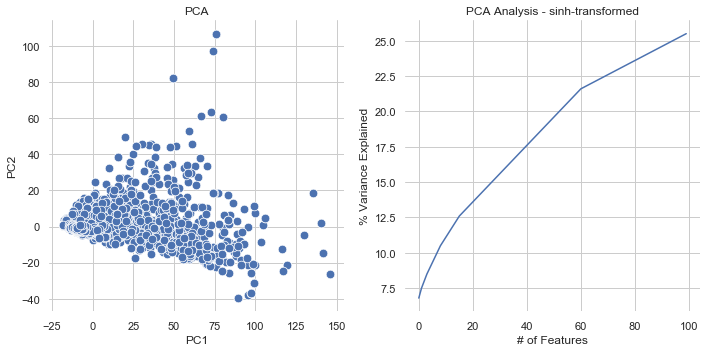

In [20]:
# Perform PCA on subsample of 500 cells with 50 components
PCA_fit = PCA(n_components=100).fit(tumor_data_1_norm)
# transform data to fit
PCA_results = PCA_fit.transform(tumor_data_1_norm)

# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(PCA_results[:,0], PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

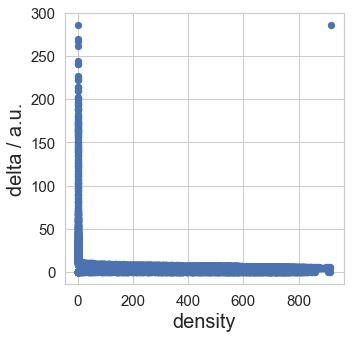

In [21]:
clu = Cluster(PCA_results) # cluster using pydpc

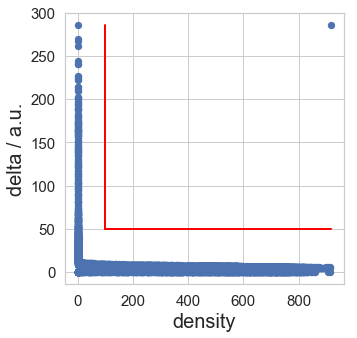

In [22]:
clu.assign(100,50) # assign cluster centers; looks like there's only one for this dataset

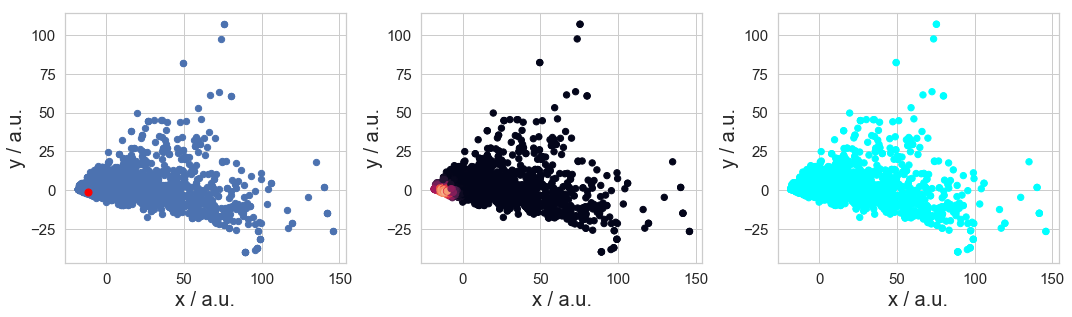

In [23]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(PCA_results[:, 0], PCA_results[:, 1], s=40)
ax[0].scatter(PCA_results[clu.clusters, 0], PCA_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(PCA_results[:, 0], PCA_results[:, 1], s=40, c=clu.density)
ax[2].scatter(PCA_results[:, 0], PCA_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

---
Let's split it up and cross-validate using `KFold`

In [8]:
kf = KFold(n_splits=5, shuffle=True)

In [18]:
%%time
# create an iterable dictionary to house training and testing sets from k-fold split of original dataset
# each training and testing matrix should be complementary, and constitute the entire dataset
# i.e. kfold_dict['train'][0].append(kfold_dict['test'][0]) = tumor_data_1
kfold_dict = {'train':[], 'test':[]}

for train, test in kf.split(tumor_data_1):
    kfold_dict['train'].append(tumor_data_1[train])
    kfold_dict['test'].append(tumor_data_1[test])

CPU times: user 1.32 s, sys: 1.59 s, total: 2.91 s
Wall time: 3.13 s


In [20]:
len(kfold_dict['test'])

5

In [21]:
len(kfold_dict['train'])

5

In [28]:
kfold_dict['train'][0].shape

(4000, 38254)

In [27]:
kfold_dict['test'][0].shape

(1000, 38254)